#### Intro to Quantum Programming - Spring 2021
## Homework 6: Due 04/23/2021

For each exercise below, add as many cells as you want. To evaluate your submission, I will do **Restart and Run All**. . For help with Markdown, see [this link](https://www.markdownguide.org/).

----
*Before doing this homework*, you must upgrade your Qiskit installation.  Open up a command prompt in your current Python environment.  (If you use Anaconda, you can go to *Environments*, click on the green triangle, and select "Open Terminal.")  

Type: `pip install -U qiskit`.

----

In [1]:
# Here's a cell for import statements... add more if necessary (or just import below as needed)
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, transpile, assemble
from qiskit import Aer, execute
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.quantum_info import Statevector
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import math
from qiskit.algorithms import QAOA
from qiskit.algorithms.optimizers import COBYLA, SPSA
from qiskit.utils import QuantumInstance
from qiskit.quantum_info.operators import Operator
from qiskit.opflow import PauliSumOp
from qiskit.quantum_info import Pauli

In this homework, we are going to solve the **MaxCut** problem for a *weighted* undirected graph. There will be many references to the Qiskit textbook example, which can be found [here](https://qiskit.org/textbook/ch-applications/qaoa.html). That example considers *unweighted* graphs.  For a *weighted* graph, the goal is to divide the graph into two partitions with the largest sum of weights between them, rather than just the largest number of edges.

This code uses the **NetworkX** Python package to build and represent a graph.  Documentation can be found [here](https://networkx.org/documentation/stable/).

The graph for this homework is shown here. There are six nodes, and the weight for each edge is shown next to the edge.

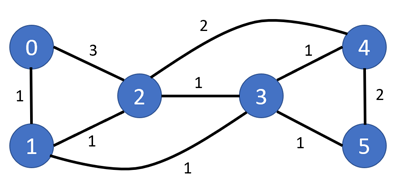


----
#### Exercise 6.1

Section 5.1 of the example shows how to create a graph using **networkx**.  Create the graph shown above and draw it. Using the code from the example, weights will not be drawn, and that's ok.  (If you want to figure out how to show the weights, that would be good for some creativity points!)

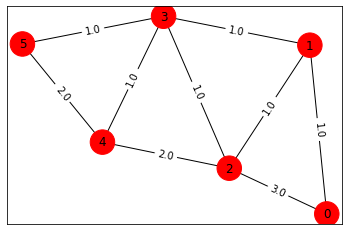

In [2]:
n = 6
V = np.arange(0,n,1)
E =[(0,1,1.0),(0,2,3.0),(1,2,1.0),(1,3,1.0),(2,3,1.0),(2,4,2.0),(3,4,1.0),(3,5,1.0),(4,5,2.0)] 

G = nx.Graph()
G.add_nodes_from(V)
G.add_weighted_edges_from(E)

# Generate plot of the Graph
colors       = ['r' for node in G.nodes()]
default_axes = plt.axes(frameon=True)
pos          = nx.spring_layout(G)

nx.draw_networkx(G, node_color=colors, node_size=600, alpha=1, ax=default_axes, pos=pos)
labels = nx.get_edge_attributes(G,'weight')
edge_labels = nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

Run the following code to show that the weights have been set properly.  This code assumes that `n` is the number of vertices and `G` is the graph; change the code if your variable names are different.  The result is an *adjacency matrix* with each matrix element being the weight of the edge between vertices.

In [3]:
# Computing the weight matrix from the random graph
weights = np.zeros([n,n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i,j,default=0)
        if temp != 0:
            weights[i,j] = temp['weight']
print(weights)

[[0. 1. 3. 0. 0. 0.]
 [1. 0. 1. 1. 0. 0.]
 [3. 1. 0. 1. 2. 0.]
 [0. 1. 1. 0. 1. 1.]
 [0. 0. 2. 1. 0. 2.]
 [0. 0. 0. 1. 2. 0.]]


----
#### Exercise 6.2

We won't calculate the expectation value or find the optimal angles manually, because the weights and the connectivity are more complex than the textbook example.  We'll move straight to building a quantum circuit.

For a graph with $V$ vertices, we use $V$ qubits. We represent the partition of the graph by assigning a value of $0$ or $1$ to each vertex.  An edge is part of the "cut" when its two vertices have different values (colors).

For an *unweighted* graph, we simply want to count all of the cut edges, because each edge is identical. For QAOA, this means we want to rotate the phase of the qubits by $\gamma$ if they are connected and have different values.  The circuit below shows a circuit that does this for two qubits connected by an edge.  The $P$ operator is the phase shift, also known as `p` or `u1` in Qiskit.  The Qiskit `cp` gate is used for a controlled-phase rotation.  See the code in section 5.3 of the example.

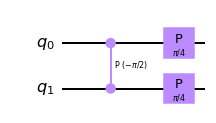

In [4]:
gamma = np.pi/4  # just an example
demo = QuantumCircuit(2)
demo.cp(-2*gamma,0,1)
demo.p(gamma,0)
demo.p(gamma,1)
demo.draw("mpl")

For a *weighted* graph, we want to rotate the qubits more if their connecting edge has a higher weight.  For example, if the weight is $3$, then rotate by $3\gamma$.  However, if the weight is too high, then we'll just end up with an over-rotation that will not properly distinguish between high weights and low weights.  For example, if $\gamma = \pi/2$, then rotating by $\gamma$ and $3\gamma$ would result in the same rotation!

Therefore, we need to scale the rotations by the largest weight in the graph.  For example, if the largest weight is 5, then we rotate a weight-5 edge by $\gamma$ and rotate a weight-1 edge by $\gamma/5$.  

After the phase rotations for each edge, we do an X rotation on every qubit, with angle = $2\beta$, as shown in the example code.


Define a *function* that returns a quantum circuit that performs the $\gamma$ and $\beta$ rotations for the Hamiltonion of a weighted graph. The arguments of your function will be gamma, beta, and the graph. You will need to learn the number of vertices and the largest weight from the graph. You will also need to read the weight for each edge from the graph. (I might change the graph or adjust the weights when evaluating your code.) See the example code for tips on how to use the graph object that you created in 6.1. (Or look [here](https://networkx.org/documentation/stable/reference/classes/graph.html).)

This circuit **must not** contain the Hadamard gates or the measurements in the example code. Just the rotations.  Draw the circuit for our graph, with $\gamma = \pi$ and $\beta = \pi/2$.

In [5]:
def performRotations(gamma, beta, graph):
    numberVertices = len(graph)
    maxEdge = max(dict(G.edges).items(), key=lambda x: x[1]['weight'])
    maxEdge = maxEdge[1].get('weight')
    least = gamma/maxEdge
  
    qc = QuantumCircuit(len(V))

    # apply the Ising type gates with angle gamma along the edges in E
    for edge in E:
        k = edge[0]
        l = edge[1]
        w = edge[2]
        gamma = least * w
        qc.cp(-2*gamma, k, l)
        qc.p(gamma, k)
        qc.p(gamma, l)

    # then apply the single qubit X rotations with angle beta to all qubits
    qc.barrier()
    qc.rx(2*beta, range(len(V)))

    ### return the circuit 
    return qc

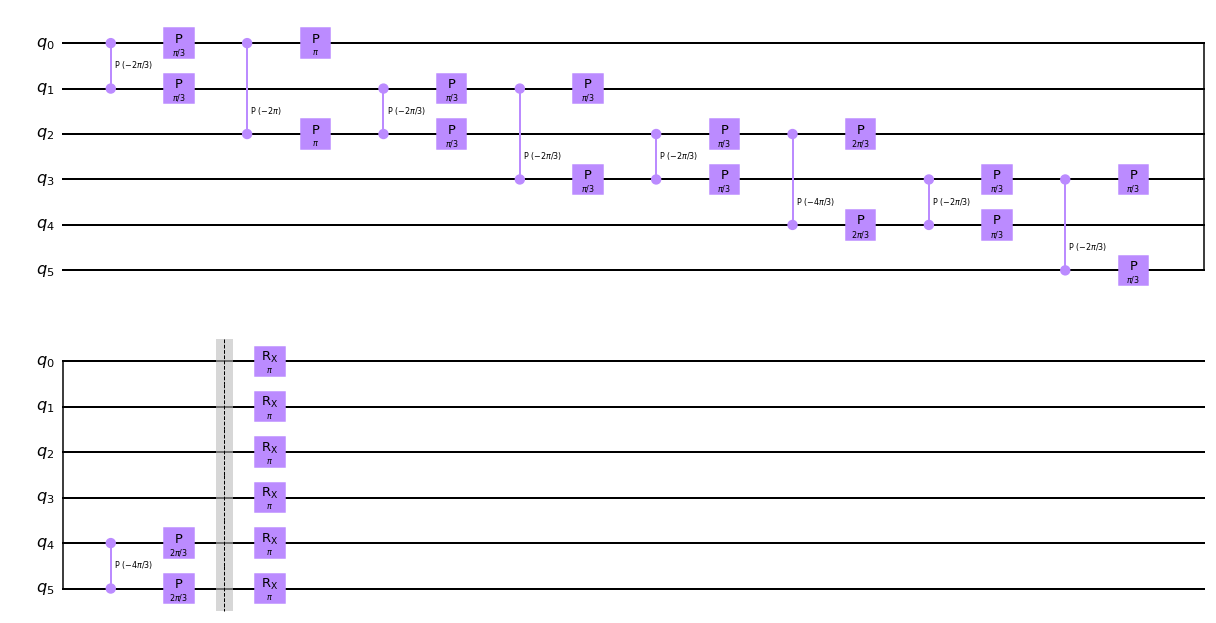

In [6]:
# Drawing an example of the performRotation with gamma = pi and beta = pi/2
qc = performRotations(np.pi, np.pi/2, G)
qc.draw("mpl")

Demonstrate your circuit for our graph, for $\gamma = \pi$ and $\beta = \pi/2$.  Show and explain the output state vector if the input is an equal supersition of 0's and 1's, i.e, $|+\rangle^{\otimes n}$.  (In other words, put Hadamard gates on all zero inputs before going into your circuit.)  What do you expect to see?  Are the results what you expect?

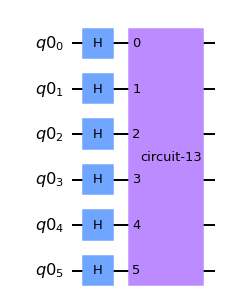

In [7]:
# Drawing an example of the performRotation with gamma = pi and betta = pi/2
qsim = Aer.get_backend('qasm_simulator')
a = QuantumRegister(len(V))
qc = QuantumCircuit(a)
for i in range(len(V)):
    qc.h(i)
qc.append(performRotations(np.pi, np.pi/2, G), a[:])
qc.draw("mpl")

In [8]:
v = Statevector.from_instruction(qc)
print(np.round(v,4))

[-0.125 +0.j      0.0625+0.1083j  0.125 -0.j     -0.0625+0.1083j
 -0.0625-0.1083j -0.0625+0.1083j  0.0625-0.1083j  0.0625+0.1083j
  0.0625+0.1083j  0.0625-0.1083j -0.0625+0.1083j -0.0625-0.1083j
  0.125 -0.j     -0.0625-0.1083j  0.0625-0.1083j  0.0625+0.1083j
 -0.0625+0.1083j  0.125 -0.j      0.0625-0.1083j  0.0625+0.1083j
  0.0625-0.1083j -0.125 +0.j      0.125 -0.j     -0.0625+0.1083j
 -0.0625-0.1083j -0.0625+0.1083j  0.0625-0.1083j  0.0625+0.1083j
  0.0625-0.1083j -0.125 +0.j     -0.0625-0.1083j  0.125 -0.j
  0.125 -0.j     -0.0625-0.1083j -0.125 +0.j      0.0625-0.1083j
  0.0625+0.1083j  0.0625-0.1083j -0.0625+0.1083j -0.0625-0.1083j
 -0.0625+0.1083j  0.125 -0.j     -0.125 +0.j      0.0625-0.1083j
  0.0625+0.1083j  0.0625-0.1083j  0.125 -0.j     -0.0625+0.1083j
  0.0625+0.1083j  0.0625-0.1083j -0.0625-0.1083j  0.125 -0.j
 -0.0625-0.1083j -0.0625+0.1083j  0.0625-0.1083j  0.0625+0.1083j
  0.0625+0.1083j  0.0625-0.1083j -0.0625+0.1083j -0.0625-0.1083j
 -0.0625+0.1083j  0.125 -0.j     

This statevector makes sense due to the gamma rotation changing the phases, and the sign based on the beta rotation. The beta rotation causes the negative / positive sign, and the phases change due to the gamma rotation. There is also a 2 x beta rotation of the circuit. The statevector makes sense and is similar to my expectations. 

----
#### Exercise 6.3
Now simulate the circuit with an input of $|+\rangle^{\otimes n}$ for 5000 shots. Display the result histogram and compute the expected value.  See the example code. (The example code separates transpile, assemble, and run, but we've been using execute, which is fine.)

Note: You can use the same cost function as the example.  Make the histogram readable, please!

In [9]:
# Compute the value of the cost function
def cost_function_C(x,G):
    
    E = G.edges()
    if( len(x) != len(G.nodes())):
        return np.nan
        
    C = 0;
    for index in E:
        e1 = index[0]
        e2 = index[1]
        
        w      = G[e1][e2]['weight']
        C = C + w*x[e1]*(1-x[e2]) + w*x[e2]*(1-x[e1])
        
    return C

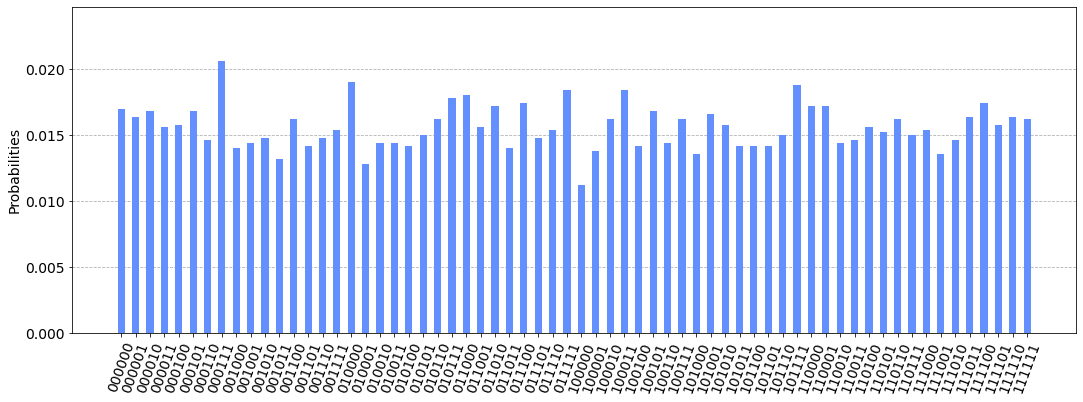

In [10]:
# run on local simulator
qc.measure_all()
backend = Aer.get_backend("qasm_simulator")
shots = 5000

TQC = transpile(qc, backend)
qobj = assemble(TQC, shots=shots)
QC_RESULTS = backend.run(qobj).result()

# qc.draw()
plot_histogram(QC_RESULTS.get_counts(),figsize = (18,6),bar_labels = False)

Discuss the results. Do they match what you expect?  Why or why not?  Show whatever information is suitable to support your discussion.  (Use a **markup cell** for this text.  If you haven't used markup yet, it's time you learned!  See the link at the top of the page for info.

The sampled mean value is M1_sampled = 6.43

The cost function is distributed as: 



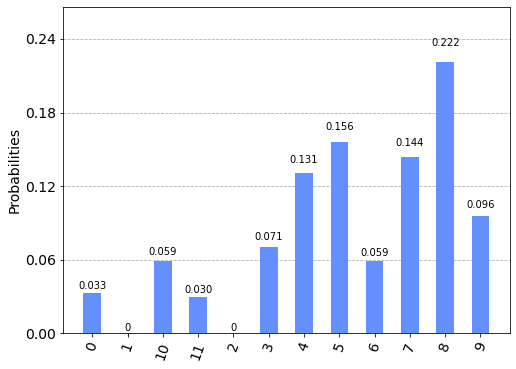

In [11]:
counts = QC_RESULTS.get_counts()

avr_C       = 0
max_C       = [0,0]
hist        = {}

for k in range(len(G.edges())+1):
    hist[str(k)] = hist.get(str(k),0)

for sample in list(counts.keys()):

    # use sampled bit string x to compute C(x)
    x         = [int(num) for num in list(sample)]
    tmp_eng   = cost_function_C(x,G)
    
    # compute the expectation value and energy distribution
    avr_C     = avr_C    + counts[sample]*tmp_eng
    hist[str(round(tmp_eng))] = hist.get(str(round(tmp_eng)),0) + counts[sample]
    
    # save best bit string
    if( max_C[1] < tmp_eng):
        max_C[0] = sample
        max_C[1] = tmp_eng
                
M1_sampled   = avr_C/shots

print('The sampled mean value is M1_sampled = %.02f\n' % (M1_sampled))
print('The cost function is distributed as: \n')
plot_histogram(hist,figsize = (8,6),bar_labels = True)

As we can see above on the graph, the solution for the max number of cuts is 8. This looks more or less correct from my solutions by hand. When I try to calculate the best solution, I personally get around 8. The solution generated for M1_sampled also looks correct, because the total weight of all of the edges together adds up to 13. Dividing this by 2 will give us a (probably not always very accurate but still quick in this case) estimation of 6.5, which compares well with our final solution. We can also see that the histogram of the energies does concentrate around the predicted mean.

----
#### Exercise 6.4
Now we'll try to use the `QAOA` class from Qiskit.  This is not like the other classes we've used.  It does not create/return a circuit.  It sets up the framework for the algorithm.  Then we call the `compute_minimum_eigenvalue` method, the simulator and optimizer run alternately to find and evaluate angles and expected values.

In [12]:
qi = QuantumInstance(Aer.get_backend('qasm_simulator'), shots=5000)
q = QAOA(COBYLA(), 1, quantum_instance=qi)  # could also use a different optimizer, such as SPSA

In [13]:
# the code in this cell is modified from some test code in Qiskit
def getOperator(weight_matrix):
    num_nodes = weight_matrix.shape[0]
    pauli_list = []
    shift = 0
    for i in range(num_nodes):
        for j in range(i):
            if weight_matrix[i, j] != 0:
                x_p = np.zeros(num_nodes, dtype=bool)
                z_p = np.zeros(num_nodes, dtype=bool)
                z_p[i] = True
                z_p[j] = True
                pauli_list.append([0.5 * weight_matrix[i, j], Pauli((z_p, x_p))])
                shift -= 0.5 * weight_matrix[i, j]
    opflow_list = [(pauli[1].to_label(), pauli[0]) for pauli in pauli_list]
    return PauliSumOp.from_list(opflow_list), shift

def sample_most_likely(state_vector):
    pp = list(state_vector.items())
    i, _ = pp[0]
    #n = int(np.log2(len(i)))
    k = np.argmax(np.abs(list(state_vector.values())))
    x = np.zeros(n)
    for i in range(n):
        x[i] = k % 2
        k >>= 1
    return x

In [14]:
op, _ = getOperator(weights)
r = q.compute_minimum_eigenvalue(operator=op)
x = sample_most_likely(r.eigenstate)
print(x)

[1. 1. 0. 0. 1. 1.]


Discuss the outcome of the experiment.  Run it multiple times and see what happens.  Do you think the results are good?  Bad?  Why?  Can you do anything to improve the outcome?  Here's the [documentation for the QAOA class](https://qiskit.org/documentation/stubs/qiskit.algorithms.QAOA.html).

I think that the results are pretty bad, because I ran it 9 times and got a different output every single time for the eigenstate. Ideally, I would expect that the answer should be more consistent or at least have some kind of a pattern to it. To improve the outcome, you could change the number of repetitions.